In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense, GRU, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from data_handler import time_series_data_handler

Using TensorFlow backend.


## Notice on data set

The dataset is measurement from real operational chemical plants. For secuiry reaseon, all data are de-titled.

### Hyper parameters for data handling

1. Input time step:
    Input time sereis has dimension of [number of input feature x input_time_step]
2. Targe time step:
    Input time sereis has dimension of [number of input feature x input_time_step]
3. Overlap:
    For the purpose of data argumentation. original time series data are splited in overlaped fashion.
    <br /> For example: X is a sequence of observations; X = X1,X2,X3,X4,X4, ... XN.
    <br /> If Input time step = 3, Overlap = 2, Then, input data collections will be as follows
    <br /> Training_X = [(X1,X2,X3),(X2,X3,X4),(X3,X4,X5), ... (XN-2,XN-1,XN)]
4. Scailing bound:
     Recurrent Neural Network is very sensitivy to the range of input features. 
     <br />Hence, all data are feature-wisely rescailed into range of scailing bound.
     
### Purpose of prediction task

The purpose of model inference is predicting 1 min future value of displacement sensor. The target system is a Forced Draft Fan in petroleum plant. Input time series are control variables and operational envoriment measurements.

In [2]:
data_path = './data/displacement.csv'
input_cols = [1,8,9,10,11]
target_cols = [11]
input_time_step = 5
target_time_step =1
time_lag = 1
overlap = 4
scaling_bound = [-1,1]

data_handler = time_series_data_handler(datapath= data_path, input_columns = input_cols,\
                                           target_columns = target_cols, input_time_step = input_time_step,\
                                            target_time_step = target_time_step, time_lag= time_lag, overlap = overlap,\
                                           scaling_bound = scaling_bound)

(5, 5, 44638)
(1, 1, 44637)


In [3]:
#### Fit into appropriate dimension ####
data_handler.train_y = np.squeeze(data_handler.train_y)
data_handler.test_y = np.squeeze(data_handler.test_y)

## Dropout and Autocorrelation

The following figure shows that target time sereis has low autocorrelation. Since the data innately has weak correlation in time domain, the model resulting has high dropout ratio in recurrent connections.

![Autocorrelation](./images/ljung_box.png)

The following figure shows variation of Valiation set MSE along the change of dropout rate on the last layer. All MSE were sampled 20 times for a fixed dropout rate.
![Autocorrelation](./images/LAST_LAYER_DR.png)



In [5]:
# create and fit the RNN
model = Sequential()
model.add(Bidirectional(GRU(150, return_sequences=True, dropout = 0.0, recurrent_dropout=0.8, recurrent_activation='tanh'), input_shape=(input_time_step, len(input_cols))))
model.add(GRU(100, return_sequences=True, dropout = 0.0, recurrent_dropout=0.8, recurrent_activation='tanh'))
model.add(GRU(50, dropout = 0.0, recurrent_dropout=0.8, recurrent_activation='tanh'))
model.add(Dense(50, activation="relu"))
model.add(Dense((target_time_step)))

# Declare a gradient descenter.
gd = Adam(lr = 0.001)

# Declare an Early stop callback.
er_callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model.compile(loss='mean_squared_error', optimizer=gd)

sample_df = 1

val_losses =[]
for _ in range(sample_df):
    _H = model.fit(data_handler.train_x, data_handler.train_y, epochs=100, batch_size=1024,\
              verbose=2, validation_split=0.2, callbacks=[er_callbacks])
    val_losses.append(min(_H.history.get('val_loss')))

Train on 28566 samples, validate on 7142 samples
Epoch 1/100
6s - loss: 0.0913 - val_loss: 0.0276
Epoch 2/100
5s - loss: 0.0278 - val_loss: 0.0244
Epoch 3/100
5s - loss: 0.0260 - val_loss: 0.0245
Epoch 4/100
5s - loss: 0.0255 - val_loss: 0.0237
Epoch 5/100
5s - loss: 0.0251 - val_loss: 0.0233
Epoch 6/100
5s - loss: 0.0248 - val_loss: 0.0232
Epoch 7/100
5s - loss: 0.0246 - val_loss: 0.0228
Epoch 8/100
5s - loss: 0.0244 - val_loss: 0.0227
Epoch 9/100
5s - loss: 0.0243 - val_loss: 0.0227
Epoch 10/100
5s - loss: 0.0241 - val_loss: 0.0225
Epoch 11/100
5s - loss: 0.0239 - val_loss: 0.0225
Epoch 12/100
5s - loss: 0.0240 - val_loss: 0.0234
Epoch 13/100
5s - loss: 0.0239 - val_loss: 0.0224
Epoch 14/100
5s - loss: 0.0238 - val_loss: 0.0222
Epoch 15/100
5s - loss: 0.0236 - val_loss: 0.0223
Epoch 16/100
5s - loss: 0.0236 - val_loss: 0.0223
Epoch 17/100
5s - loss: 0.0235 - val_loss: 0.0223
Epoch 18/100
5s - loss: 0.0235 - val_loss: 0.0223
Epoch 19/100
5s - loss: 0.0235 - val_loss: 0.0221
Epoch 20/1

In [6]:
# evaluate models
trainPredict = model.predict(data_handler.train_x)
testPredict = model.predict(data_handler.test_x)

# take inverse transform.
trainPredict = data_handler.target_data_scaler.inverse_transform(trainPredict)
trainY = data_handler.target_data_scaler.inverse_transform(data_handler.train_y)

testPredict = data_handler.target_data_scaler.inverse_transform(testPredict)
testY = data_handler.target_data_scaler.inverse_transform(data_handler.test_y)

/home/jyp/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/jyp/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [7]:
# Plotting
testPredicitonPlot = np.squeeze(testPredict)
testTruthPlot = np.squeeze(testY)

In [8]:
target_cols = [3]

data_handler_origin = time_series_data_handler(datapath= data_path, input_columns = input_cols,\
                                           target_columns = target_cols, input_time_step = input_time_step,\
                                            target_time_step = target_time_step, time_lag= time_lag, overlap = overlap,\
                                              scaling_bound = scaling_bound)

(5, 5, 44638)
(1, 1, 44637)


In [9]:
data_handler_origin.test_y = np.squeeze(data_handler_origin.test_y)
unenveloped_y = data_handler_origin.target_data_scaler.inverse_transform(data_handler_origin.test_y)
test_unenveloped_y = np.squeeze(unenveloped_y)

/home/jyp/tensorflow/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


## Test set predciton result

The blue bold line is a prediction result. The green line is corresponding ground truth. Model was able to predict displacement mesaurement. Remember that autocorrelation in target time series alomst is 0.1. This is a quite surprising result.

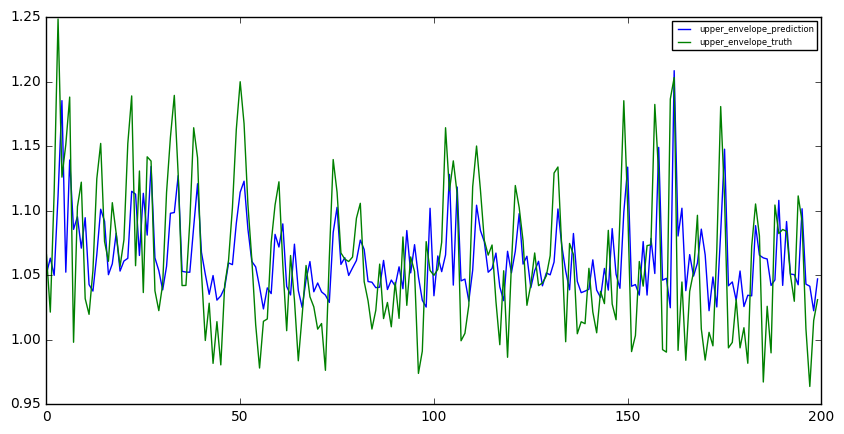

In [10]:
starting_idx = 0
ending_idx = 200

fig = plt.figure(figsize=(10, 5), dpi=100)
pr_pred, = plt.plot(testPredicitonPlot[starting_idx:ending_idx], label="upper_envelope_prediction")
pr_truth, = plt.plot(testTruthPlot[starting_idx:ending_idx], label="upper_envelope_truth")
plt.legend(handles=[pr_pred,pr_truth], loc=1,prop={'size':6})

plt.show()

In [11]:
trainPredicitonPlot = np.squeeze(trainPredict)
trainTruthPlot = np.squeeze(trainY)

## Traing set predciton result

The blue bold line is a prediction result. The green line is a corresponding ground truth.

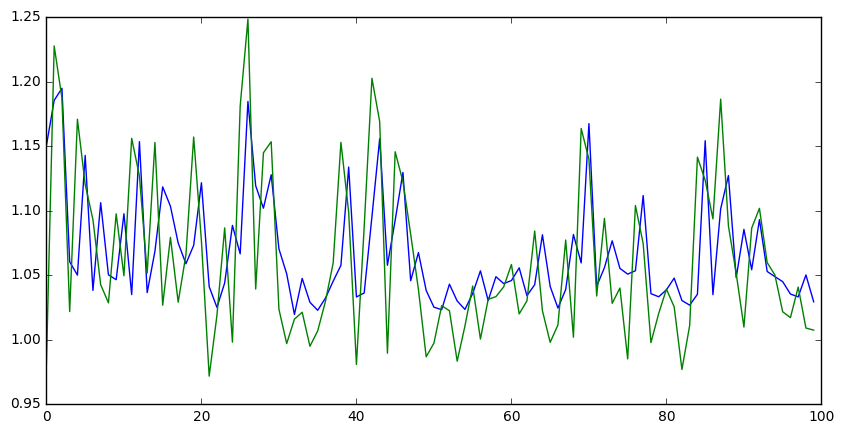

In [12]:
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(trainPredicitonPlot[0:100])
plt.plot(trainTruthPlot[0:100])
plt.show()